In [1]:
import time 
import getdist
import emcee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.integrate import quad, odeint
from getdist import plots, MCSamples
from astropy.convolution import Gaussian1DKernel
%matplotlib inline

# Omegam, delta, zc, beta from IDL inversely calibrate local SN

In [2]:
IDL = emcee.backends.HDFBackend("../Chains/IDL=HFSN+2DBAO+CC/PDE.h5",
                                read_only=True)
tau = IDL.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainIDL = IDL.get_chain(discard=burnin, flat=True, thin=thin)

In [3]:
# read the SN data

Pantheonplus_Data = pd.read_csv("../Data/Pantheon+SH0ES.dat", sep='\s+')

Pantheonplus_Data = Pantheonplus_Data[["CID", "zHD", "zCMB", "zHEL", "m_b_corr", 
                                                                     "CEPH_DIST", "IS_CALIBRATOR",
                                                                     "USED_IN_SH0ES_HF"]]

Pantheonplus_covariance = pd.read_csv("../Data/Pantheon+SH0ES_STAT+SYS.cov",
                                                                  sep='\s+').values.reshape(1701, 1701)

local_SN = Pantheonplus_Data.query("zHD<0.0233")

ndim = local_SN.shape[0]
SN_cov = np.zeros((ndim, ndim))
SN_cov_index = local_SN.index
SN_cov = np.array([Pantheonplus_covariance[SN_cov_index[i], SN_cov_index[j]]
                                for i in range(0, ndim) for j in range(0, ndim)
                                ]).reshape(ndim, ndim)

inverse_SN_cov = np.matrix(SN_cov).I


class PDE():
    def __init__(self,
                 H0=70,
                 Magnitude=-19.2,
                 rd=147,
                 Omegam=0.3,
                 Delta=0.3,
                 zc=0.1,
                 beta=2):
        self.Omegam = Omegam
        self.OmegaL = 1 - Omegam
        self.Omegak = 0
        self.H0 = H0
        self.rd = rd
        self.Magnitude = Magnitude
        self.Delta = Delta
        self.zc = zc
        self.beta = beta
        self.H0Mpc = H0 / 2.998e5  #Mpc^{-1}

    def Hofz(self, z):  #Ez = Hz/h/100
        Ez = np.sqrt(self.Omegam * (1 + z)**3 + self.OmegaL *
                     (1 + self.Delta * np.exp(-(z / self.zc)**self.beta)))
        return (Ez)

    def Hofa(self, a):
        return np.sqrt(self.Omegam / a**3 + self.OmegaL *
                       (1 + self.Delta * np.exp(-(
                           (1 / a - 1) / self.zc)**self.beta)))

    def Comoving_distance(self, z):
        
        def dchibydz(znow):
            return 1 / self.Hofz(znow)

        def dC(znow):
            I = quad(dchibydz, 0, znow)[0]
            return (I)

        if (type(z) == np.ndarray):
            dc = [dC(znow) for znow in z]
            return (np.array(dc))
        
        else:
            return dC(z)

    def dL(self, zcmb):
        return (1 + zcmb) * self.Comoving_distance(zcmb)

    def calc_aB(self, SN_z_data, inver_cov):

        dL_vector = np.matrix(
            [np.log10(self.dL(zn)) for zn in SN_z_data["zHD"].values])

        mB_vector = np.matrix(0.2 * SN_z_data["m_b_corr"].values)

        delta_vector = dL_vector - mB_vector

        aB = np.sum(inver_cov * delta_vector.T) / np.sum(inver_cov)

        return aB


"""
Here is inverse calibration chain, only need to run once
"""
#aB_PDEparam_IDL = np.array([PDE(0,0, 0, Om, delta, zc, beta).calc_aB(local_SN, inverse_SN_cov) for H0, MB, rd, Om, delta, zc, beta in tqdm(flatchainIDL)])
#np.save("../Figure3/aB_PDEparam_IDL.npy", aB_PDEparam_IDL)

'\nHere is inverse calibration chain, only need to run once\n'

# Note: it is important to transform H0f to H0

In [4]:
def PDE_Hz(Om, delta, zc, beta, z):
    OmL = 1-Om
    Ez = np.sqrt(Om*(1+z)**3+OmL*(1+delta*np.exp(-(z/zc)**beta)))
    return Ez

def transform_H0(chain):
    H0f_array, Om_array, delta_array, zc_array, beta_array = chain[:, 0], chain[:, -4], chain[:, -3], chain[:, -2], chain[:, -1]
    H0 = PDE_Hz(Om_array, delta_array, zc_array, beta_array, 0) * H0f_array
    return H0

In [5]:
PDE_IDL = emcee.backends.HDFBackend("../Chains/IDL=HFSN+2DBAO+CC/PDE.h5",
                                    read_only=True)

tau = PDE_IDL.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainPDE_IDL = PDE_IDL.get_chain(discard=burnin, flat=True, thin=thin)

flatchainPDE_IDL[:, 0] = transform_H0(flatchainPDE_IDL)

/tmp/ipykernel_44603/4125021496.py:3: RuntimeWarning: divide by zero encountered in power
  Ez = np.sqrt(Om*(1+z)**3+OmL*(1+delta*np.exp(-(z/zc)**beta)))


In [6]:
PDE_MB_IDL = emcee.backends.HDFBackend("../Chains/MB(IDL)+LocalSN/PDE.h5",
                                       read_only=True)

tau = PDE_MB_IDL.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainPDE_MB_IDL = PDE_MB_IDL.get_chain(discard=burnin,
                                           flat=True,
                                           thin=thin)

flatchainPDE_MB_IDL[:, 0] = transform_H0(flatchainPDE_MB_IDL)

/tmp/ipykernel_44603/4125021496.py:3: RuntimeWarning: divide by zero encountered in power
  Ez = np.sqrt(Om*(1+z)**3+OmL*(1+delta*np.exp(-(z/zc)**beta)))


In [7]:
PDE_MB_SH0ES_HFSN = emcee.backends.HDFBackend(
    "../Chains/MB(SH0ES)+HFSN/PDE.h5", read_only=True)

tau = PDE_MB_SH0ES_HFSN.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainPDE_MB_SH0ES_HFSN = PDE_MB_SH0ES_HFSN.get_chain(discard=burnin,
                                                         flat=True,
                                                         thin=thin)

flatchainPDE_MB_SH0ES_HFSN[:, 0] = transform_H0(flatchainPDE_MB_SH0ES_HFSN)

/tmp/ipykernel_44603/4125021496.py:3: RuntimeWarning: divide by zero encountered in power
  Ez = np.sqrt(Om*(1+z)**3+OmL*(1+delta*np.exp(-(z/zc)**beta)))


In [8]:
PDE_MB_SH0ES_localSN = emcee.backends.HDFBackend(
    "../Chains/MB(SH0ES)+LocalSN/PDE.h5", read_only=True)

tau = PDE_MB_SH0ES_localSN.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

flatchainPDE_MB_SH0ES_localSN = PDE_MB_SH0ES_localSN.get_chain(discard=burnin,
                                                               flat=True,
                                                               thin=thin)

flatchainPDE_MB_SH0ES_localSN[:,
                              0] = transform_H0(flatchainPDE_MB_SH0ES_localSN)

In [9]:
def calculate_aB(H0_array, MB_array):

    aB = -0.2 * (MB_array + 25 - 5 * np.log10(H0_array) +
                 5 * np.log10(2.998e5))

    return aB

In [10]:
IDL = calculate_aB(flatchainPDE_IDL[:, 0] , flatchainPDE_IDL[:, 1] )

MB_IDL = calculate_aB(flatchainPDE_MB_IDL[:, 0], flatchainPDE_MB_IDL[:, 1])

MB_SH0ES_HFSN = calculate_aB(flatchainPDE_MB_SH0ES_HFSN[:, 0], flatchainPDE_MB_SH0ES_HFSN[:, 1])

MB_SH0ES_localSN = calculate_aB(flatchainPDE_MB_SH0ES_localSN[:, 0], flatchainPDE_MB_SH0ES_localSN[:, 1])


PDEparam_IDL = np.load("aB_PDEparam_IDL.npy")

In [11]:
# params = tuple(['a_B'])
# IDL_aB = MCSamples(samples=IDL, names=params, labels=params)
# MB_IDL_aB = MCSamples(samples=MB_IDL, names=params, labels=params)
# MB_SH0ES_HFSN_aB = MCSamples(samples=MB_SH0ES_HFSN, names=params, labels=params)
# MB_SH0ES_localSN_aB = MCSamples(samples=MB_SH0ES_localSN, names=params, labels=params)
# PDEparam_IDL_aB = MCSamples(samples=PDEparam_IDL, names=params, labels=params)

In [12]:
k = Gaussian1DKernel(4)


def Gaussian_processing(chain, bins):
    prob, aB = np.histogram(chain, bins=bins, range=None)
    prob = np.convolve(prob, k, mode='same')
    prob = prob / prob.max()
    return prob, aB[1:]

In [13]:
IDL_probabilitydensity = Gaussian_processing(IDL, 100)

MB_IDL_probabilitydensity = Gaussian_processing(MB_IDL, 300)

PDEparam_IDL_probabilitydensity = Gaussian_processing(PDEparam_IDL, 100)

MB_SH0ES_HFSN_probabilitydensity = Gaussian_processing(MB_SH0ES_HFSN, 300)

MB_SH0ES_localSN_probabilitydensity = Gaussian_processing(
    MB_SH0ES_localSN, 300)

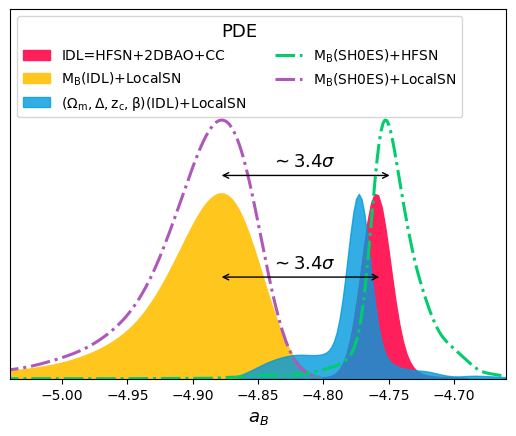

In [14]:
plt.fill_between(IDL_probabilitydensity[1],
                 IDL_probabilitydensity[0],
                 y2=0,
                 color='#FF1F5B',
                 alpha=1)

plt.fill_between(MB_IDL_probabilitydensity[1],
                 MB_IDL_probabilitydensity[0],
                 y2=0,
                 color='#FFC61E',
                 alpha=1)

plt.fill_between(PDEparam_IDL_probabilitydensity[1],
                 PDEparam_IDL_probabilitydensity[0],
                 y2=0,
                 color='#009ADE',
                 alpha=0.8)

plt.plot(MB_SH0ES_HFSN_probabilitydensity[1],
         MB_SH0ES_HFSN_probabilitydensity[0] * 1.4,
         color='#00CD6C',
         lw=2.2,
         linestyle='-.')

plt.plot(MB_SH0ES_localSN_probabilitydensity[1],
         MB_SH0ES_localSN_probabilitydensity[0] * 1.4,
         color='#AF58BA',
         lw=2.2,
         linestyle='-.')

plt.xticks(np.arange(-5.2, -4.6, 0.05), fontsize=10)
plt.yticks([])
plt.xlim(-5.04, -4.66)
plt.ylim(0, 2)

plt.legend(labels=[
    'IDL=HFSN+2DBAO+CC',
    r'$\mathrm{M_B}$(IDL)+LocalSN',
    r'($\mathrm{\Omega_m, \Delta, z_c, \beta}$)(IDL)+LocalSN',
    r'$\mathrm{M_B}$(SH0ES)+HFSN',
    r'$\mathrm{M_B}$(SH0ES)+LocalSN',
],
           loc='upper left',
           title='PDE',
           fontsize=10,
           title_fontsize=13,
           ncol=2)

plt.annotate(text='',
             xy=(-4.88, 0.55),
             xytext=(-4.755, 0.55),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim3.4\sigma$',
             xy=(-4.84, 0.6),
             xytext=(-4.84, 0.6),
             arrowprops=None,
             fontsize=13)

plt.annotate(text='',
             xy=(-4.88, 1.1),
             xytext=(-4.747, 1.1),
             arrowprops=dict(arrowstyle='<->'))
plt.annotate(text='$\sim3.4\sigma$',
             xy=(-4.84, 1.15),
             xytext=(-4.84, 1.15),
             arrowprops=None,
             fontsize=13)

plt.xlabel("$a_B$", fontsize=13)
plt.savefig("PDE-aB-probility.pdf", dpi=1000, bbox_inches='tight')